# Get probabilistic mass measurements for Kepler-431 using Forecaster.

In [19]:
import numpy as np
import forecaster.mr_forecast as mr
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import pandas as pd
import time
import pickle 
from collections import OrderedDict
from generatefeatures import generate_features
%matplotlib inline

Get mass samples for Kepler-431 using data from NASAEA and Morton et al. (2016) - http://adsabs.harvard.edu/abs/2016ApJ...822...86M

In [20]:
#mean/std radius measurements, earth radii
mu1, std1 = 0.77, 0.15    
mu2, std2 = 0.76, 0.15
mu3, std3 = 1.08, 0.205

n_samples = 500

#generate samples from normal distribution
r1 = np.random.normal(mu1,std1,n_samples)
r2 = np.random.normal(mu2,std2,n_samples)
r3 = np.random.normal(mu3,std3,n_samples)

#radius samples -> probabilistic mass samples
m1 = mr.Rpost2M(r1, unit='Earth', grid_size=1e3, classify='Yes')  #earth masses
m2 = mr.Rpost2M(r2, unit='Earth', grid_size=1e3, classify='Yes')
m3 = mr.Rpost2M(r3, unit='Earth', grid_size=1e3, classify='Yes')

Terran 92.6 %, Neptunian 7.4 %, Jovian 0.0 %, Star 0.0 %
Terran 95.6 %, Neptunian 4.4 %, Jovian 0.0 %, Star 0.0 %
Terran 75.4 %, Neptunian 24.6 %, Jovian 0.0 %, Star 0.0 %


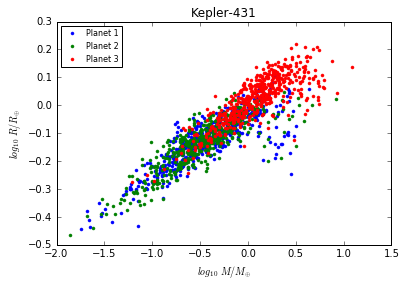

In [21]:
plt.plot(np.log10(m1), np.log10(r1), '.', label='Planet 1')
plt.plot(np.log10(m2), np.log10(r2), '.', label='Planet 2')
plt.plot(np.log10(m3), np.log10(r3), '.', label='Planet 3')
plt.xlabel(r'$log_{10}\ M/M_{\oplus}$')
plt.ylabel(r'$log_{10}\ R/R_{\oplus}$')
plt.legend(loc='upper left', numpoints=1, fontsize=8)
plt.title('Kepler-431')

## Generate Dataframe for Kepler-431

In [22]:
P1, P2, P3 = 6.803, 8.703, 11.922

#truncated norm: a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
std = 0.2
h1, k1 = truncnorm(-1/std,1/std,scale=std).rvs(size=n_samples),truncnorm(-1/std,1/std,scale=std).rvs(size=n_samples)
h2, k2 = truncnorm(-1/std,1/std,scale=std).rvs(size=n_samples),truncnorm(-1/std,1/std,scale=std).rvs(size=n_samples)
h3, k3 = truncnorm(-1/std,1/std,scale=std).rvs(size=n_samples),truncnorm(-1/std,1/std,scale=std).rvs(size=n_samples)
MA1, MA2, MA3 = 2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples),2*np.pi*np.random.random(n_samples)

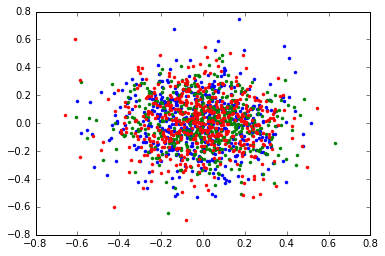

In [23]:
plt.plot(h1, k1, '.')
plt.plot(h2, k2, '.')
plt.plot(h3, k3, '.')

In [24]:
data = []
for i in range(n_samples):
    data.append([m1[i],MA1[i],P1,h1[i],k1[i],m2[i],MA2[i],P2,h2[i],k2[i],m3[i],MA3[i],P3,h3[i],k3[i]])
data = pd.DataFrame(np.asarray(data),columns=["m1","MA1","P1","h1","k1","m2","MA2","P2","h2","k2","m3","MA3","P3","h3","k3"])

In [26]:
data.head()

,m1,MA1,P1,h1,k1,m2,MA2,P2,h2,k2,m3,MA3,P3,h3,k3
0,1.283002,0.273125,6.803,-0.004646,-0.016753,0.436326,0.801487,8.703,-0.115972,0.162392,1.256664,0.874393,11.922,0.035613,-0.119452
1,0.059572,0.684592,6.803,-0.059569,-0.061400,0.393342,5.894609,8.703,0.240576,-0.186022,0.717799,1.377012,11.922,-0.112623,0.018522
2,0.168052,0.272111,6.803,-0.000686,-0.189300,0.206787,0.983747,8.703,0.055905,-0.193149,2.067338,2.555880,11.922,-0.159714,0.102554
3,2.200065,2.434525,6.803,0.208773,-0.023141,0.259783,1.278485,8.703,-0.034965,0.148973,1.546320,2.979259,11.922,0.197192,-0.000702
4,1.393989,3.237444,6.803,0.052262,0.121939,1.230867,5.470081,8.703,-0.196727,0.221984,2.293250,5.614621,11.922,-0.151338,0.095350


In [27]:
def predict_system(system,data,Ms,n_sims,model,save_data,epoch=0):
    
    # run models
    start = time.time()
    fullfeatures = []
    for index, d in data.iterrows():
        fullfeatures.append(generate_features(d, Ms, epoch))
    print "%d simulations took %f seconds"%(n_sims, time.time() - start)
    
    model = pickle.load(open('OptimalXGBmodel.pkl', 'rb'))
    
    features = []
    features += ['avg_iH1', 'avg_iH2']
    features += ['norm_std_a1', 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1']
    features += ['norm_std_a2', 'norm_max_a2', 'norm_std_window10_a2', 'norm_max_window10_a2']
    features += ['norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3']
    features += ['avg_ecross1', 'std_ecross1', 'max_ecross1', 'min_ecross1']
    features += ['avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2']
    features += ['avg_ecross3', 'std_ecross3', 'max_ecross3', 'min_ecross3']
    features += ['norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope']
    features += ['Lyapunov_time']
    
    # compile results - take only the features the model uses
    results = pd.DataFrame(columns=features)
    for i in range(len(fullfeatures)):
        results.loc[i] = fullfeatures[i][features] 
        
    # predict stability 
    results["predict_proba"] = model.predict_proba(results)[:,1]
    
    data.to_csv("systems/%s_data.csv"%system)
    results.to_csv("systems/%s_results.csv"%system)
    return data, results

Parameters needed for model

In [28]:
Ms = 1.071                      #Solar mass units
model = "OptimalXGBmodel.pkl"   #pre-trained machine learning model
save_data = 1

In [29]:
data, results = predict_system("Kepler-431",data,Ms,n_samples,model,save_data)

500 simulations took 25.201945 seconds
